In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from templates import *

In [3]:
device = 'cuda:0'
conf = ffhq256_autoenc()
# print(conf.name)
model = LitModel(conf)
state = torch.load(f'checkpoints/{conf.name}/last.ckpt', map_location='cpu')
model.load_state_dict(state['state_dict'], strict=False)
model.ema_model.eval()
model.ema_model.to(device);

Global seed set to 0


Model params: 160.69 M


In [4]:
img_from_dir = 'imgs_align/'
for i,file in enumerate(os.listdir(img_from_dir)):
    print(f'{i}: {file}')

0: azuki_default.png
1: ceo_default.png
2: check1.png
3: check2.png
4: danda_default.png
5: detective.png
6: detective_02.png
7: idPhoto.png
8: mio_happy.png
9: mio_shock.png
10: mio_silence.png
11: mio_u.png
12: nanko_default.png
13: ookawa_angry.png
14: ookawa_angry2.png
15: ookawa_default.png
16: ookawa_high.png
17: ookawa_regret.png
18: ookawa_smile.png
19: ookawa_surprised.png
20: pharmacist.png
21: saki.png
22: saki_glasses.png
23: sandy.png
24: takebe_default.png
25: test01.png
26: test01_02.png
27: test01_03.png
28: test01_04.png
29: test02.png
30: woman_default.png
31: yotaka_angry.png
32: yotaka_angry2.png
33: yotaka_bald.png
34: yotaka_bushy.png
35: yotaka_default.png
36: yotaka_gj.png
37: yotaka_smile.png
38: yotaka_smile2.png


In [5]:
img_to_dir = 'imgs_align/'
for i,file in enumerate(os.listdir(img_to_dir)):
    print(f'{i}: {file}')

0: azuki_default.png
1: ceo_default.png
2: check1.png
3: check2.png
4: danda_default.png
5: detective.png
6: detective_02.png
7: idPhoto.png
8: mio_happy.png
9: mio_shock.png
10: mio_silence.png
11: mio_u.png
12: nanko_default.png
13: ookawa_angry.png
14: ookawa_angry2.png
15: ookawa_default.png
16: ookawa_high.png
17: ookawa_regret.png
18: ookawa_smile.png
19: ookawa_surprised.png
20: pharmacist.png
21: saki.png
22: saki_glasses.png
23: sandy.png
24: takebe_default.png
25: test01.png
26: test01_02.png
27: test01_03.png
28: test01_04.png
29: test02.png
30: woman_default.png
31: yotaka_angry.png
32: yotaka_angry2.png
33: yotaka_bald.png
34: yotaka_bushy.png
35: yotaka_default.png
36: yotaka_gj.png
37: yotaka_smile.png
38: yotaka_smile2.png


In [25]:
data = ImageDataset(img_from_dir, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
ind_batch_from = [15]
batch_from = np.array(data[ind_batch_from[0]]['img'][None])
names_batch_from = [os.path.splitext(str(data.paths[ind_batch_from[0]]))[0]]
for i in range(1, len(ind_batch_from)):
    batch_from = np.append(batch_from, data[ind_batch_from[i]]['img'][None], axis=0)
    names_batch_from.append(os.path.splitext(str(data.paths[ind_batch_from[i]]))[0])
batch_from = torch.tensor(batch_from)

data2 = ImageDataset(img_to_dir, image_size=conf.img_size, exts=['jpg', 'JPG', 'png'], do_augment=False)
ind_batch_to = [14]
batch_to = np.array(data2[ind_batch_to[0]]['img'][None])
names_batch_to = [os.path.splitext(str(data2.paths[ind_batch_to[0]]))[0]]
for i in range(1, len(ind_batch_to)):
    batch_to = np.append(batch_to, data2[ind_batch_to[i]]['img'][None], axis=0)
    names_batch_to.append(os.path.splitext(str(data2.paths[ind_batch_to[i]]))[0])
batch_to = torch.tensor(batch_to)

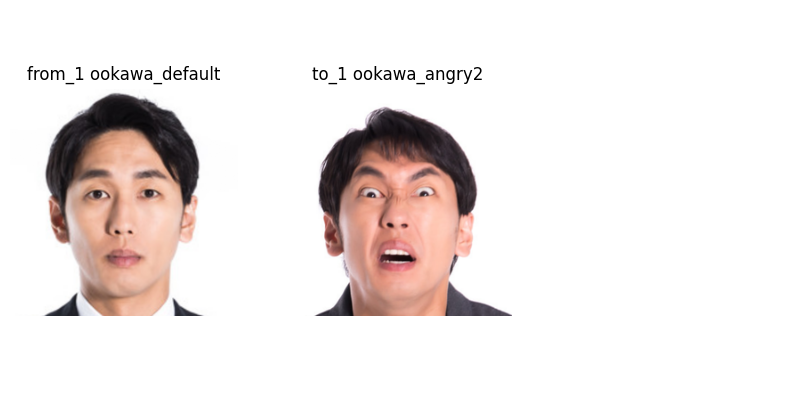

In [26]:
import matplotlib.pyplot as plt

num_from = len(batch_from)
num_to = len(batch_to)
fig, ax = plt.subplots(1, 2+num_to, figsize=(5*(num_from+num_to), 5))
for i in range(num_from):
    ax[i].imshow(batch_from[i].permute([1, 2, 0]) / 2 + 0.5)
    ax[i].set_title(f"from_{i+1} {names_batch_from[i]}")

for i in range(num_to):
    ax[i+num_from].imshow(batch_to[i].permute([1, 2, 0]) / 2 + 0.5)
    ax[i+num_from].set_title(f"to_{i+1} {names_batch_to[i]}")

for i in range(2+num_to):
    ax[i].axis('off')
plt.show()

In [27]:
cond_from = model.encode(batch_from.to(device))
xT_from = model.encode_stochastic(batch_from.to(device), cond_from, T=250)

cond_to = model.encode(batch_to.to(device))
xT_to = model.encode_stochastic(batch_to.to(device), cond_to, T=250)

## Interpolate

Semantic codes are interpolated using convex combination, while stochastic codes are interpolated using spherical linear interpolation.

In [28]:
torch.cuda.empty_cache()

**slerp**

In [29]:
import numpy as np
alpha = torch.tensor(np.linspace(0, 1, 11, dtype=np.float32)).to(device)
# alpha[:, None] = alpha.unsqueeze(dim=1)

def cos(a, b):
    a = a.view(-1)
    b = b.view(-1)
    a = F.normalize(a, dim=0)
    b = F.normalize(b, dim=0)
    return (a * b).sum()

preds = []
for i in range(len(cond_from)):
    for j in range(len(cond_to)):
        preds_tmp = []
        for a in alpha:
            torch.cuda.empty_cache()
            intp = cond_from[i][None] * (1 - a) + cond_to[j][None] * a
            theta = torch.arccos(cos(xT_from[i], xT_to[j]))
            x_shape = xT_from[i].shape
            intp_x = (torch.sin((1 - a) * theta) * xT_from[i].flatten(0, 2)[None] + torch.sin(a * theta) * xT_to[j].flatten(0, 2)[None]) / torch.sin(theta)
            intp_x = intp_x.view(-1, *x_shape)
            pred = model.render(intp_x, intp, T=20)
            preds_tmp.append(pred[0])
        preds.append(preds_tmp)

**lerp**

In [27]:
import numpy as np
alpha = torch.tensor(np.linspace(0, 1, 11, dtype=np.float32)).to(device)

preds = []
for i in range(len(cond_from)):
    for j in range(len(cond_to)):
        preds_tmp = []
        for a in alpha:
            torch.cuda.empty_cache()
            intp = cond_from[i][None] * (1 - a) + cond_to[j][None] * a
            x_shape = xT_from[i].shape
            intp_x = (1-a) * xT_from[i].flatten(0, 2)[None] + a * xT_to[j].flatten(0, 2)[None]
            intp_x = intp_x.view(-1, *x_shape)
            pred = model.render(intp_x, intp, T=20)
            preds_tmp.append(pred[0])
        preds.append(preds_tmp)

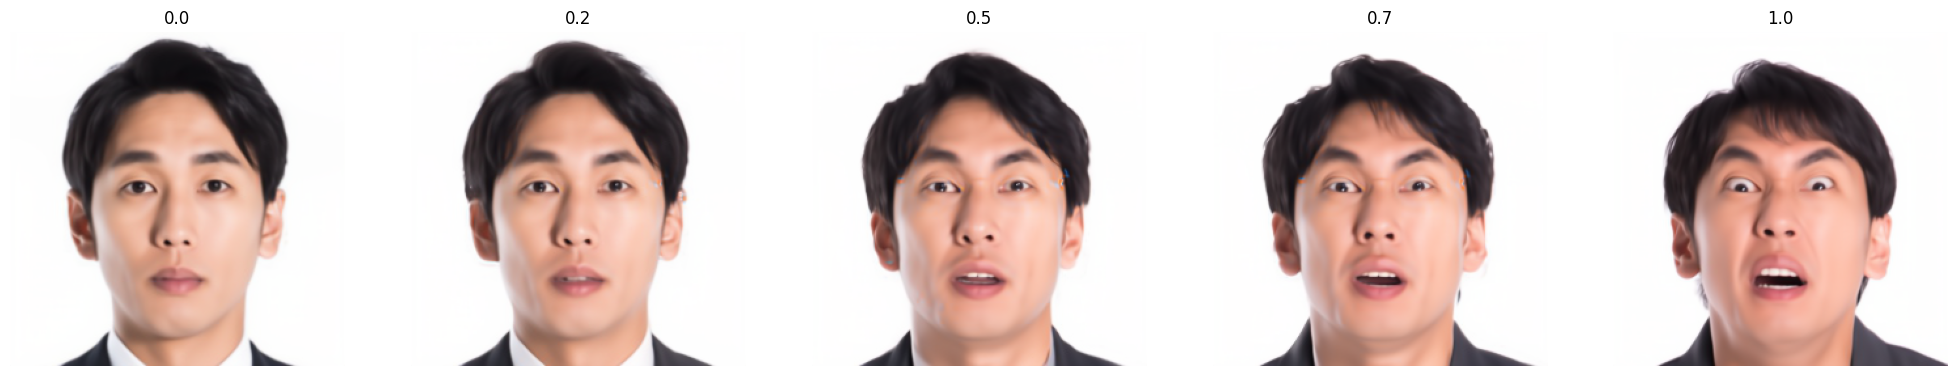

In [30]:
import matplotlib.pyplot as plt

num_show = 5
fig,ax = plt.subplots(num_to, num_show, figsize=(5*num_show, 5*num_to))
for i,pred in enumerate(preds):
    for j,k in enumerate(np.linspace(0,len(pred)-1,num_show,dtype=np.uint8)):
        if len(preds) < 2:
            ax[j].imshow(pred[k].permute(1,2,0).cpu())
            ax[j].set_title(np.array(alpha[k].cpu()))
            ax[j].axis('off')
        else:
            ax[i,j].imshow(pred[k].permute(1,2,0).cpu())
            if i == 0:
                ax[i,j].set_title(np.array(alpha[k].cpu()))
            ax[i,j].axis('off')

In [31]:
from PIL import Image

preds_pil = []
for pred in preds:
    pred_pil = []
    for p in pred:
        p_np = np.array((p*255).permute(1,2,0).cpu()).astype(np.uint8)
        pred_pil.append(Image.fromarray(p_np))
    preds_pil.append(pred_pil)

## gifの保存

### 名前自動（まとめて）

In [32]:
dst_dir = "imgs_test/imgs_interpolate/"
for i,pred_pil in enumerate(preds_pil):
    frs_dir = f"{dst_dir}{names_batch_from[i//len(names_batch_to)]}2{names_batch_to[i%len(names_batch_to)]}/"
    if not os.path.exists(frs_dir): os.makedirs(frs_dir)
    file_name = f"amp{np.array(alpha.detach().cpu())[0]:.2f}_{np.array(alpha.detach().cpu())[-1]:.2f}_{len(alpha)}.gif"
    dst_path = frs_dir + file_name

    pred_pil[0].save(
        dst_path,
        format="gif",
        save_all=True,
        append_images=pred_pil,
        duration=3000//(len(alpha)-1),
        loop=0,
    )

### 名前手動（ひとつずつ）

In [69]:
for i,name_from in enumerate(names_batch_from):
    for j,name_to in enumerate(names_batch_to):
        print(f'{len(names_batch_to)*i+j:2}: {name_from}  →  {name_to}')

 0: yotaka_default  →  azuki_default
 1: yotaka_default  →  danda_default
 2: yotaka_default  →  nanko_default
 3: yotaka_default  →  ookawa_default
 4: yotaka_default  →  takebe_default
 5: yotaka_default  →  woman_default
 6: mio_silence  →  azuki_default
 7: mio_silence  →  danda_default
 8: mio_silence  →  nanko_default
 9: mio_silence  →  ookawa_default
10: mio_silence  →  takebe_default
11: mio_silence  →  woman_default


In [82]:
index = 0
dst_dir = "imgs_test/imgs_interpolate/"
file_name = "yotaka2woman.gif"
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
dst_path = dst_dir + file_name

preds_pil[index][0].save(
    dst_path,
    format="gif",
    save_all=True,
    append_images=preds_pil[index],
    duration=120//(len(alpha)-1),
    loop=0,
)

## 静止画像（フレーム）の保存

### 名前自動（まとめて）

In [33]:
from torchvision.utils import save_image

# select_ind = {0,12,24,36,47,59}
select_ind = {0,2,4,6,8,10}
dst_dir = "imgs_test/imgs_interpolate/"
for i,pred in enumerate(preds):
    frs_dir = f"{dst_dir}{names_batch_from[i//len(names_batch_to)]}2{names_batch_to[i%len(names_batch_to)]}/"
    if not os.path.exists(frs_dir): os.makedirs(frs_dir)
    for j,p in enumerate(pred):
        if j in select_ind:
            file_name = f"{frs_dir}amp{np.array(alpha.detach().cpu())[j]:.2f}.png"
            save_image(p, file_name, format='PNG')

### 名前手動（ひとつずつ）

In [77]:
print('index: name')
for i, name in enumerate(names_batch_to):
    print(f'{i:5}: {name}')

index: name
    0: azuki_default
    1: danda_default
    2: nanko_default
    3: ookawa_default
    4: takebe_default
    5: woman_default


In [37]:
print('index: amplitude')
for i,a in enumerate(np.array(alpha.detach().cpu())):
    print(f'{i:5}: {a}')

index: amplitude
    0: 0.0
    1: 0.016949152573943138
    2: 0.033898305147886276
    3: 0.050847455859184265
    4: 0.06779661029577255
    5: 0.08474576473236084
    6: 0.10169491171836853
    7: 0.11864406615495682
    8: 0.1355932205915451
    9: 0.1525423675775528
   10: 0.16949152946472168
   11: 0.18644067645072937
   12: 0.20338982343673706
   13: 0.22033898532390594
   14: 0.23728813230991364
   15: 0.2542372941970825
   16: 0.2711864411830902
   17: 0.2881355881690979
   18: 0.3050847351551056
   19: 0.32203391194343567
   20: 0.33898305892944336
   21: 0.35593220591545105
   22: 0.37288135290145874
   23: 0.38983049988746643
   24: 0.4067796468734741
   25: 0.4237288236618042
   26: 0.4406779706478119
   27: 0.4576271176338196
   28: 0.47457626461982727
   29: 0.49152541160583496
   30: 0.508474588394165
   31: 0.5254237055778503
   32: 0.5423728823661804
   33: 0.5593220591545105
   34: 0.5762711763381958
   35: 0.5932203531265259
   36: 0.6101694703102112
   37: 0.627118

In [ ]:
index_name = 0
index_amp = 0
dst_dir = "imgs_test/imgs_interpolate/"
file_name = "yotaka2smile-trans-women.png"
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)
dst_path = dst_dir + file_name
save_image(preds[index_name][index_amp], dst_path)

In [20]:
from PIL import Image

preds_pil = []
for p in preds:
    p_np = np.array((p*255).permute(1,2,0).cpu()).astype(np.uint8)
    preds_pil.append(Image.fromarray(p_np))

In [21]:
dst_dir = "imgs_test/imgs_interpolate/"
file_name = "yotaka2smile.gif"
if not os.path.exists(dst_dir):
    os.mkdir(dst_dir)
dst_path = dst_dir + file_name

preds_pil[0].save(
    dst_path,
    format="gif",
    save_all=True,
    append_images=preds_pil,
    duration=33,
    loop=0,
)

In [32]:
from torchvision.utils import save_image

index = 59
dst_dir = "imgs_test/imgs_interpolate/"
file_name = "yotaka2smile_%02d.png" % index
dst_path = dst_dir + file_name
if not os.path.exists(dst_dir):
    os.makedirs(dst_dir)

save_image(preds[index], dst_path)